# Caverns with constraints

In [1]:
import os
import cartopy.crs as ccrs
import contextily as cx
import geopandas as gpd
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from matplotlib.lines import Line2D
from matplotlib_scalebar.scalebar import ScaleBar

from src import functions as fns

In [2]:
# basemap cache directory
cx.set_cache_dir(os.path.join("data", "basemaps"))

## Halite data

In [3]:
ds, extent = fns.read_dat_file(dat_path=os.path.join("data", "kish-basin"))

In [4]:
xmin, ymin, xmax, ymax = extent.total_bounds

## Constraints

### Exploration wells

In [5]:
# 500 m buffer - suggested in draft OREDP II p. 108
wells, wells_b = fns.constraint_exploration_well(
    data_path=os.path.join(
        "data",
        "exploration-wells-irish-offshore",
        "Exploration_Wells_Irish_Offshore.shapezip.zip",
    )
)

### Wind farms

In [6]:
# the shapes are used as is without a buffer - suggested for renewable energy
# test site areas in draft OREDP II p. 109
wind_farms = fns.constraint_wind_farm(
    data_path=os.path.join(
        "data",
        "wind-farms-foreshore-process",
        "wind-farms-foreshore-process.zip",
    ),
    dat_extent=extent,
)

### Frequent shipping routes

In [7]:
# 1 NM (1,852 m) buffer - suggested in draft OREDP II p. 108
shipping, shipping_b = fns.constraint_shipping_routes(
    data_path=os.path.join(
        "data", "shipping", "shipping_frequently_used_routes.zip"
    ),
    dat_extent=extent,
)

### Shipwrecks

In [8]:
# Archaeological Exclusion Zones recommendation - 100 m buffer
shipwrecks, shipwrecks_b = fns.constraint_shipwrecks(
    data_path=os.path.join(
        "data", "heritage", "IE_GSI_MI_Shipwrecks_IE_Waters_WGS84_LAT.zip"
    ),
    dat_extent=extent,
)

### Subsea cables

In [9]:
# 750 m buffer - suggested in draft OREDP II p. 109-111
cables, cables_b = fns.constraint_subsea_cables(
    data_path=os.path.join("data", "kis-orca", "KIS-ORCA.gpkg")
)

### Distance from salt formation edge

In [10]:
edge_buffer = fns.constraint_halite_edge(dat_xr=ds)

## Zones of interest

In [11]:
# height = 85 m, 500 m <= depth <= 2,000 m, diameter = 80 m,
# separation = 320 m
zones, zds = fns.zones_of_interest(
    dat_xr=ds, constraints={"height": 85, "min_depth": 500, "max_depth": 2000}
)

## Generate caverns

### Exclude only shipping routes, wind farms, and cables

In [13]:
caverns, caverns_excl = fns.generate_caverns_with_constraints(
    zones_gdf=zones,
    zones_ds=zds,
    dat_extent=extent,
    exclusions={"shipping": shipping_b},
)

Without constraints...
Number of potential caverns: 4,336
------------------------------------------------------------
Exclude salt formation edges...
No data specified!
------------------------------------------------------------
Exclude frequent shipping routes...
Number of potential caverns: 1,910
Caverns excluded: 55.95%
------------------------------------------------------------
Exclude subsea cables...
No data specified!
------------------------------------------------------------
Exclude wind farms...
No data specified!
------------------------------------------------------------
Exclude exploration wells...
No data specified!
------------------------------------------------------------
Exclude shipwrecks...
No data specified!


In [16]:
caverns, caverns_excl = fns.generate_caverns_with_constraints(
    zones_gdf=zones,
    zones_ds=zds,
    dat_extent=extent,
    exclusions={"cables": cables_b},
)

Without constraints...
Number of potential caverns: 4,336
------------------------------------------------------------
Exclude salt formation edges...
No data specified!
------------------------------------------------------------
Exclude frequent shipping routes...
No data specified!
------------------------------------------------------------
Exclude subsea cables...
Number of potential caverns: 4,123
Caverns excluded: 4.91%
------------------------------------------------------------
Exclude wind farms...
No data specified!
------------------------------------------------------------
Exclude exploration wells...
No data specified!
------------------------------------------------------------
Exclude shipwrecks...
No data specified!


In [17]:
caverns, caverns_excl = fns.generate_caverns_with_constraints(
    zones_gdf=zones,
    zones_ds=zds,
    dat_extent=extent,
    exclusions={"wind_farms": wind_farms},
)

Without constraints...
Number of potential caverns: 4,336
------------------------------------------------------------
Exclude salt formation edges...
No data specified!
------------------------------------------------------------
Exclude frequent shipping routes...
No data specified!
------------------------------------------------------------
Exclude subsea cables...
No data specified!
------------------------------------------------------------
Exclude wind farms...
Number of potential caverns: 3,964
Caverns excluded: 8.58%
------------------------------------------------------------
Exclude exploration wells...
No data specified!
------------------------------------------------------------
Exclude shipwrecks...
No data specified!


### Exclude all

In [18]:
caverns, caverns_excl = fns.generate_caverns_with_constraints(
    zones_gdf=zones,
    zones_ds=zds,
    dat_extent=extent,
    exclusions={
        "wells": wells_b,
        "wind_farms": wind_farms,
        "shipwrecks": shipwrecks_b,
        "shipping": shipping_b,
        "cables": cables_b,
        "edge": edge_buffer,
    },
)

Without constraints...
Number of potential caverns: 4,336
------------------------------------------------------------
Exclude salt formation edges...
Number of potential caverns: 4,247
Caverns excluded: 2.05%
------------------------------------------------------------
Exclude frequent shipping routes...
Number of potential caverns: 1,835
Caverns excluded: 57.68%
------------------------------------------------------------
Exclude subsea cables...
Number of potential caverns: 1,751
Caverns excluded: 59.62%
------------------------------------------------------------
Exclude wind farms...
Number of potential caverns: 1,390
Caverns excluded: 67.94%
------------------------------------------------------------
Exclude exploration wells...
Number of potential caverns: 1,390
Caverns excluded: 67.94%
------------------------------------------------------------
Exclude shipwrecks...
Number of potential caverns: 1,390
Caverns excluded: 67.94%


In [21]:
caverns.describe()[["Thickness", "TopDepth"]]

,Thickness,TopDepth
count,1390.000000,1390.000000
mean,301.271103,1032.944181
std,82.154311,417.252534
min,175.062400,420.019200
25%,235.347600,695.388100
50%,291.285400,966.166300
75%,353.398775,1361.360500
max,754.985800,1917.627900


In [19]:
# excluded areas
caverns_excl.describe()[["Thickness", "TopDepth"]]

,Thickness,TopDepth
count,2946.000000,2946.000000
mean,294.692623,879.186094
std,93.819436,355.598578
min,175.055500,420.077800
25%,231.302000,595.259800
50%,272.269550,785.423450
75%,332.559450,1104.248075
max,992.179400,1919.885000


In [20]:
# label caverns by height and depth
caverns = fns.label_caverns(
    cavern_df=caverns,
    heights=[85, 155, 311],
    depths={"min": 500, "min_opt": 1000, "max_opt": 1500, "max": 2000},
)

## Crop data layers

In [15]:
# land boundary
land = fns.read_shapefile_from_zip(
    data_path=os.path.join(
        "data", "boundaries", "osi-provinces-ungeneralised-2019.zip"
    )
)

land = land.dissolve().to_crs(fns.CRS)

In [16]:
# create exclusion buffer
buffer = pd.concat([wells_b, shipwrecks_b, shipping_b, cables_b]).dissolve()

In [17]:
# crop land areas from constraints and the buffer
# biospheres = biospheres.overlay(land, how="difference")
shipping = shipping.overlay(land, how="difference")
cables = cables.overlay(land, how="difference")
buffer = buffer.overlay(land, how="difference")

In [18]:
# # merge salt edge buffer
# buffer_edge = pd.concat(buffer_edge.values()).dissolve()

## Maps

In [19]:
def plot_map(dat_xr):
    """
    Helper function to plot halite layer and caverns within the zones of
    interest
    """

    # initialise figure
    plt.figure(figsize=(12, 8))
    axis = plt.axes(projection=ccrs.epsg(fns.CRS))

    # # configure colour bar based on variable
    # if var == "TopTWT":
    #     units = "ms"
    # else:
    #     units = "m"
    # cbar_label = f"{dat_xr[var].attrs['long_name']} [{units}]"
    # if stat == "max":
    #     plot_data = dat_xr.max(dim="halite", skipna=True)
    #     cbar_label = f"Maximum Halite {cbar_label}"
    # elif stat == "min":
    #     plot_data = dat_xr.min(dim="halite", skipna=True)
    #     cbar_label = f"Minimum Halite {cbar_label}"
    # elif stat == "mean":
    #     plot_data = dat_xr.mean(dim="halite", skipna=True)
    #     cbar_label = f"Mean Halite {cbar_label}"

    # # plot halite data
    # plot_data[var].plot.contourf(
    #     cmap="jet", alpha=.65, robust=True, levels=15,
    #     cbar_kwargs={"label": cbar_label}
    # )

    # halite boundary - use buffering to smooth the outline
    shape = fns.halite_shape(dat_xr=dat_xr).buffer(1000).buffer(-1000)

    # configure map limits
    # plt.xlim(xmin - 1450, xmax + 500)
    # plt.ylim(ymin - 500, ymax + 500)
    plt.xlim(shape.bounds["minx"][0] - 10000, shape.bounds["maxx"][0] + 1500)
    plt.ylim(shape.bounds["miny"][0] - 1500, shape.bounds["maxy"][0] + 1500)

    # configure legend entries
    legend_handles = []

    shape.plot(ax=axis, zorder=1, linewidth=0, facecolor="white", alpha=0.35)
    shape.plot(
        ax=axis,
        edgecolor=sns.color_palette("flare", 4)[-2],
        color="none",
        linewidth=2,
        zorder=3,
    )
    legend_handles.append(
        mpatches.Patch(
            facecolor="none",
            linewidth=2,
            label="Kish Basin boundary",
            edgecolor=sns.color_palette("flare", 4)[-2],
        )
    )

    # add constraint layers
    for df, color, label in zip(
        [buffer.overlay(wind_farms, how="difference"), wind_farms],
        ["slategrey", sns.color_palette("GnBu", 10)[-1]],
        ["Exclusion buffer", "Wind farm"],
    ):
        df.plot(
            ax=axis, facecolor="none", hatch="//", edgecolor=color, zorder=1
        )
        legend_handles.append(
            mpatches.Patch(
                facecolor="none", hatch="//", edgecolor=color, label=label
            )
        )

    for df, color, linewidth, label in zip(
        [cables, shipping],
        [sns.color_palette("GnBu", 10)[-4], sns.color_palette("flare", 4)[0]],
        [2, 3],
        ["Subsea cable", "Shipping route"],
    ):
        df.plot(ax=axis, color=color, linewidth=linewidth, zorder=2)
        legend_handles.append(
            Line2D([0], [0], color=color, label=label, linewidth=linewidth)
        )

    for df, marker, label in zip(
        [wells, shipwrecks], ["x", "+"], ["Exploration well", "Shipwreck"]
    ):
        df.plot(ax=axis, color="black", marker=marker, zorder=4)
        legend_handles.append(
            Line2D(
                [0],
                [0],
                marker=marker,
                linewidth=0,
                markeredgecolor="black",
                label=label,
            )
        )

    # add basemap and map elements
    cx.add_basemap(axis, crs=fns.CRS, source=cx.providers.CartoDB.Voyager)
    axis.gridlines(
        draw_labels={"bottom": "x", "left": "y"},
        alpha=0.25,
        color="darkslategrey",
    )
    axis.add_artist(
        ScaleBar(1, box_alpha=0, location="lower right", color="darkslategrey")
    )
    plt.legend(
        loc="lower right", bbox_to_anchor=(1, 0.05), handles=legend_handles
    )
    plt.title(None)

    plt.tight_layout()
    plt.show()

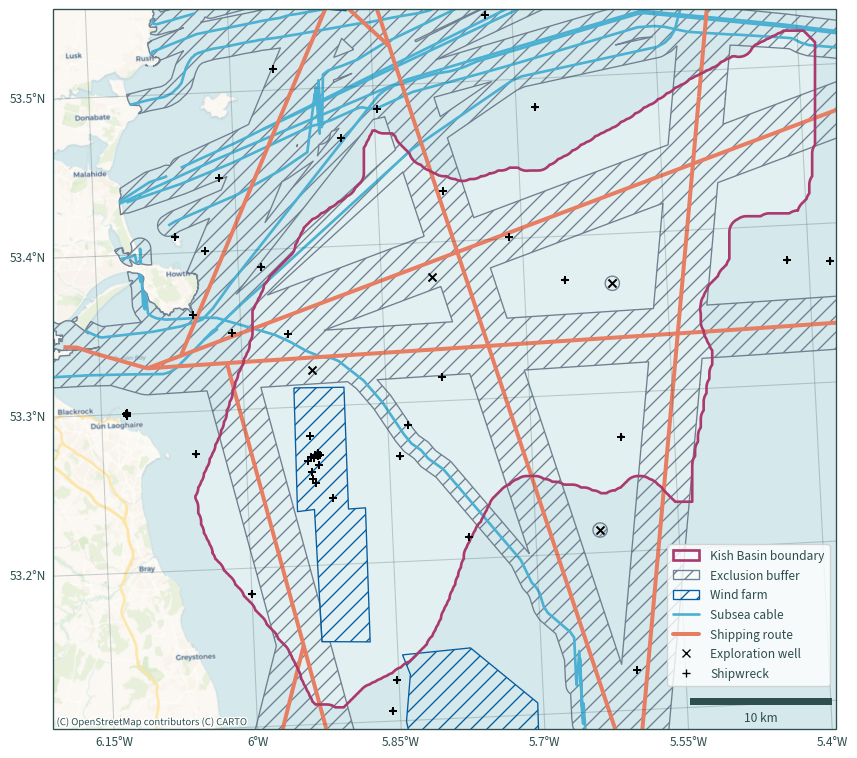

In [20]:
plot_map(ds)

In [20]:
def plot_map_alt(dat_xr, cavern_df, zones_gdf):
    """
    Helper function to plot caverns within the zones of interest
    """

    plt.figure(figsize=(20, 11.5))
    axis = plt.axes(projection=ccrs.epsg(fns.CRS))
    legend_handles = []

    # halite boundary - use buffering to smooth the outline
    shape = fns.halite_shape(dat_xr=dat_xr).buffer(1000).buffer(-1000)
    shape.plot(
        ax=axis,
        edgecolor="darkslategrey",
        color="none",
        linewidth=2,
        alpha=0.5,
        zorder=2,
    )
    legend_handles.append(
        mpatches.Patch(
            facecolor="none",
            linewidth=2,
            edgecolor="darkslategrey",
            label="Kish Basin boundary",
            alpha=0.5,
        )
    )

    zones_gdf.plot(
        ax=axis, zorder=1, linewidth=0, facecolor="white", alpha=0.45
    )
    zones_gdf.plot(
        ax=axis,
        zorder=2,
        edgecolor="slategrey",
        linestyle="dotted",
        linewidth=1.25,
        facecolor="none",
    )
    legend_handles.append(
        mpatches.Patch(
            facecolor="none",
            linestyle="dotted",
            edgecolor="slategrey",
            label="Feasible area",
            linewidth=1.25,
        )
    )

    pd.concat([buffer, wind_farms]).dissolve().clip(shape).plot(
        ax=axis,
        facecolor="none",
        linewidth=0.65,
        edgecolor="slategrey",
        zorder=2,
        alpha=0.5,
        hatch="//",
    )
    legend_handles.append(
        mpatches.Patch(
            facecolor="none",
            hatch="//",
            edgecolor="slategrey",
            label="Exclusion area",
            alpha=0.65,
            linewidth=0.5,
        )
    )

    for df, markersize in zip(
        [
            cavern_df[cavern_df["depth"] == "500 - 1,000"],
            cavern_df[cavern_df["depth"] == "1,000 - 1,500"],
            cavern_df[cavern_df["depth"] == "1,500 - 2,000"],
        ],
        [20, 50, 20],
    ):
        gpd.GeoDataFrame(df, geometry=df.centroid).plot(
            ax=axis,
            column="Thickness",
            zorder=3,
            markersize=markersize,
            cmap=sns.color_palette("flare", as_cmap=True),
            linewidth=0,
            marker=".",
            scheme="UserDefined",
            classification_kwds={"bins": [155 + 90, 311 + 90]},
        )
    legend_handles.append(
        mpatches.Patch(label="Cavern height [m]", visible=False)
    )
    palette = [
        sns.color_palette("flare", 256)[0],
        sns.color_palette("flare", 256)[127],
        sns.color_palette("flare", 256)[-1],
    ]
    for color, label in zip(palette, ["85", "155", "311"]):
        # legend_handles.append(
        #     Line2D(
        #         [0], [0], marker="o", linewidth=0, label=label, color=color
        #     )
        # )
        legend_handles.append(mpatches.Patch(facecolor=color, label=label))
    legend_handles.append(
        mpatches.Patch(label="Cavern top depth [m]", visible=False)
    )
    for markersize, label in zip(
        [6, 3], ["1,000 - 1,500", "500 - 1,000 or \n1,500 - 2,000"]
    ):
        legend_handles.append(
            Line2D(
                [0],
                [0],
                marker=".",
                linewidth=0,
                label=label,
                color="darkslategrey",
                markersize=markersize,
            )
        )

    plt.xlim(shape.bounds["minx"][0] - 1000, shape.bounds["maxx"][0] + 1000)
    plt.ylim(shape.bounds["miny"][0] - 1000, shape.bounds["maxy"][0] + 1000)

    cx.add_basemap(
        axis, crs=fns.CRS, source=cx.providers.CartoDB.VoyagerNoLabels
    )
    axis.gridlines(
        draw_labels={"bottom": "x", "left": "y"},
        alpha=0.25,
        color="darkslategrey",
    )
    axis.add_artist(
        ScaleBar(1, box_alpha=0, location="lower right", color="darkslategrey")
    )
    plt.legend(
        loc="lower right",
        bbox_to_anchor=(1, 0.05),
        handles=legend_handles,
        fontsize=11.5,
    )

    plt.tight_layout()
    plt.show()

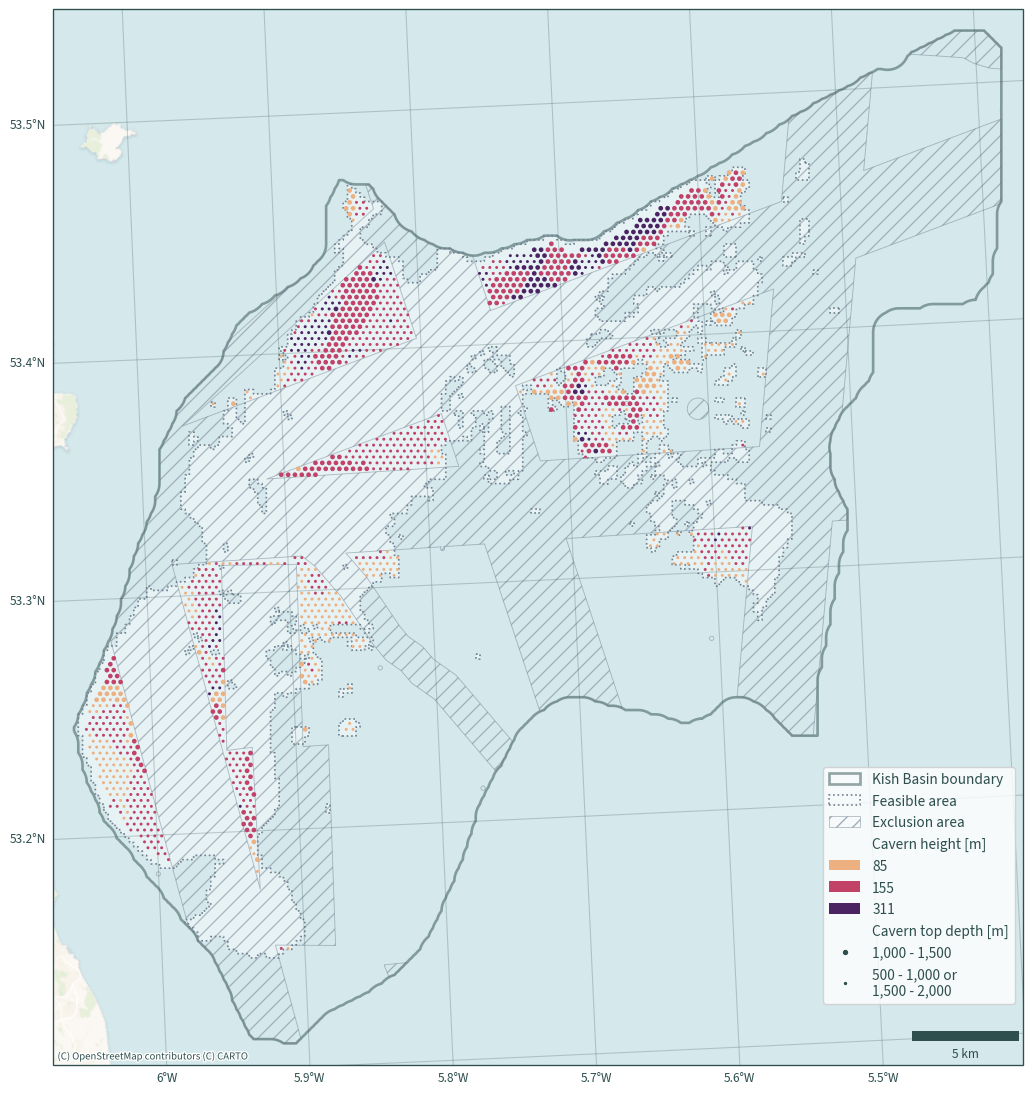

In [21]:
plot_map_alt(ds, caverns, zones)

## Stats

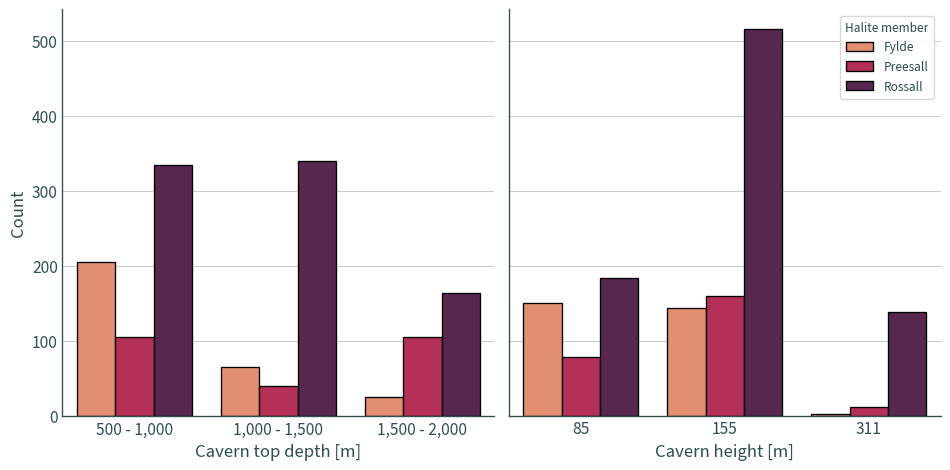

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
sns.countplot(
    caverns.sort_values("halite"),
    ax=axes[0],
    x="depth",
    hue="halite",
    palette="rocket_r",
    legend=False,
    order=["500 - 1,000", "1,000 - 1,500", "1,500 - 2,000"],
    edgecolor="black",
)
axes[0].set_xlabel("Cavern top depth [m]")
sns.countplot(
    caverns.sort_values("halite"),
    ax=axes[1],
    x="height",
    hue="halite",
    palette="rocket_r",
    order=["85", "155", "311"],
    edgecolor="black",
)
axes[1].set_xlabel("Cavern height [m]")
axes[0].set_ylabel("Count")
axes[0].grid(which="major", axis="y")
axes[1].grid(which="major", axis="y")
plt.legend(title="Halite member")
sns.despine()
plt.tight_layout()
plt.show()

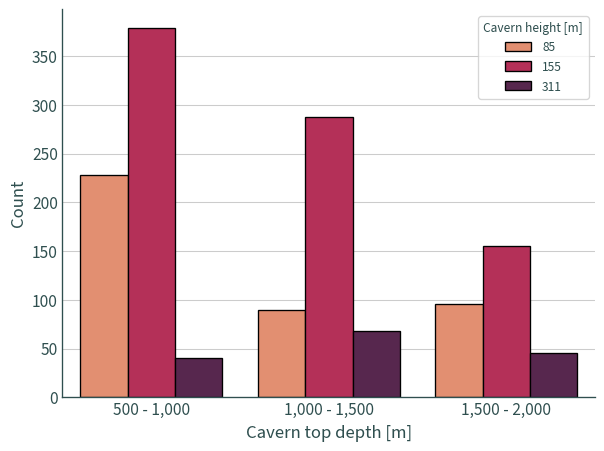

In [26]:
ax = sns.countplot(
    caverns.sort_values("Thickness"),
    x="depth",
    hue="height",
    palette="rocket_r",
    order=["500 - 1,000", "1,000 - 1,500", "1,500 - 2,000"],
    edgecolor="black",
)
ax.set_xlabel("Cavern top depth [m]")
ax.set_ylabel("Count")
ax.grid(which="major", axis="y")
sns.despine()
plt.legend(title="Cavern height [m]")
plt.tight_layout()
plt.show()

In [52]:
s = (
    caverns.sort_values("Thickness")
    .groupby("height", sort=False)
    .count()[["geometry"]]
)
s["%"] = s["geometry"] / len(caverns) * 100
s

,geometry,%
height,,
85,414,29.784173
155,822,59.136691
311,154,11.079137


In [53]:
s = (
    caverns.sort_values("TopDepth")
    .groupby("depth", sort=False)
    .count()[["geometry"]]
)
s["%"] = s["geometry"] / len(caverns) * 100
s

,geometry,%
depth,,
"500 - 1,000",647,46.546763
"1,000 - 1,500",446,32.086331
"1,500 - 2,000",297,21.366906


In [54]:
s = caverns.groupby(["height", "depth"], sort=False).count()[["geometry"]]
s["%"] = s["geometry"] / len(caverns) * 100
s

geometry          %
height depth                             
311    1,000 - 1,500        68   4.892086
       500 - 1,000          40   2.877698
       1,500 - 2,000        46   3.309353
155    1,000 - 1,500       288  20.719424
       1,500 - 2,000       155  11.151079
       500 - 1,000         379  27.266187
85     1,000 - 1,500        90   6.474820
       1,500 - 2,000        96   6.906475
       500 - 1,000         228  16.402878